In [26]:
import sys
sys.path.append('..')

from src.loader import InsuranceCrossSellingDataset
from src.analyse import InsuranceDataProcessor
from src.featureEngineering import FeatureEngineering
from src.visualization import Visualization
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
data_loader = InsuranceCrossSellingDataset(data_dir='../data')
train_df, test_df, submission_df = data_loader.load_data()

Téléchargement des données avec l'API Kaggle...
Les fichiers de données existent déjà, pas de téléchargement.
Données téléchargées et chargées avec succès.


In [3]:
processor = InsuranceDataProcessor()
train_stats = processor.analyze_dataset(train_df,'train_dataset')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB

train_dataset - Data overview:
   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   0    Male   21                1         35.0                   0   
1   1    Male   43                1         28.0                   0   
2   2  Female   25                1         14.0                   1   
3   3  Female

In [4]:
numerical_df = train_df[['id', 'Age', 'Annual_Premium']]
ordinal_df = train_df[['Region_Code', 'Policy_Sales_Channel', 'Vintage']]
categorical_df = train_df.drop(columns=numerical_df+ordinal_df)
visu = Visualization()

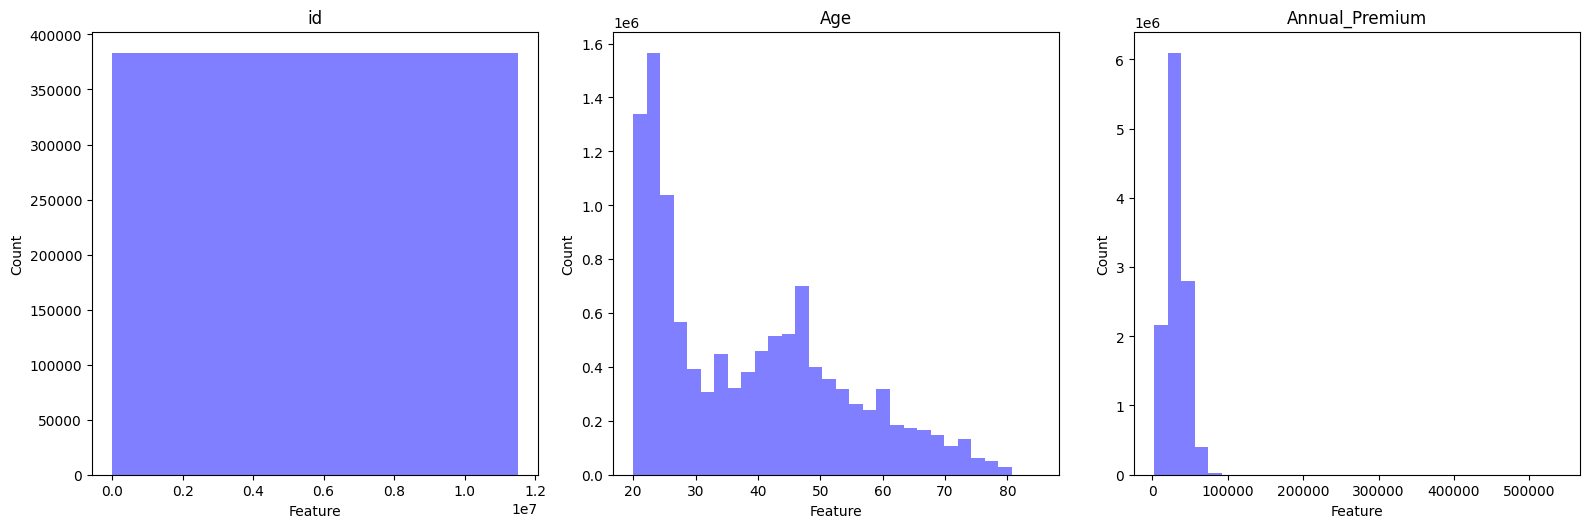

In [5]:
visu.data_overview_visualization_1(numerical_df, 'blue')

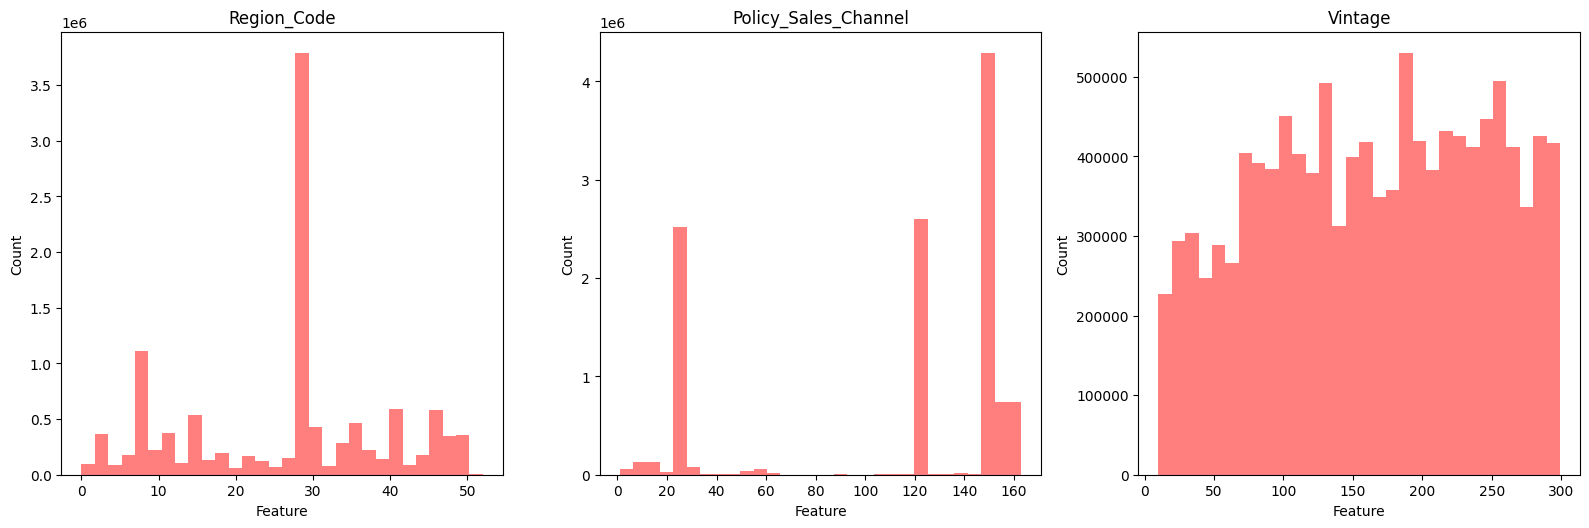

In [6]:
visu.data_overview_visualization_1(ordinal_df, 'red')

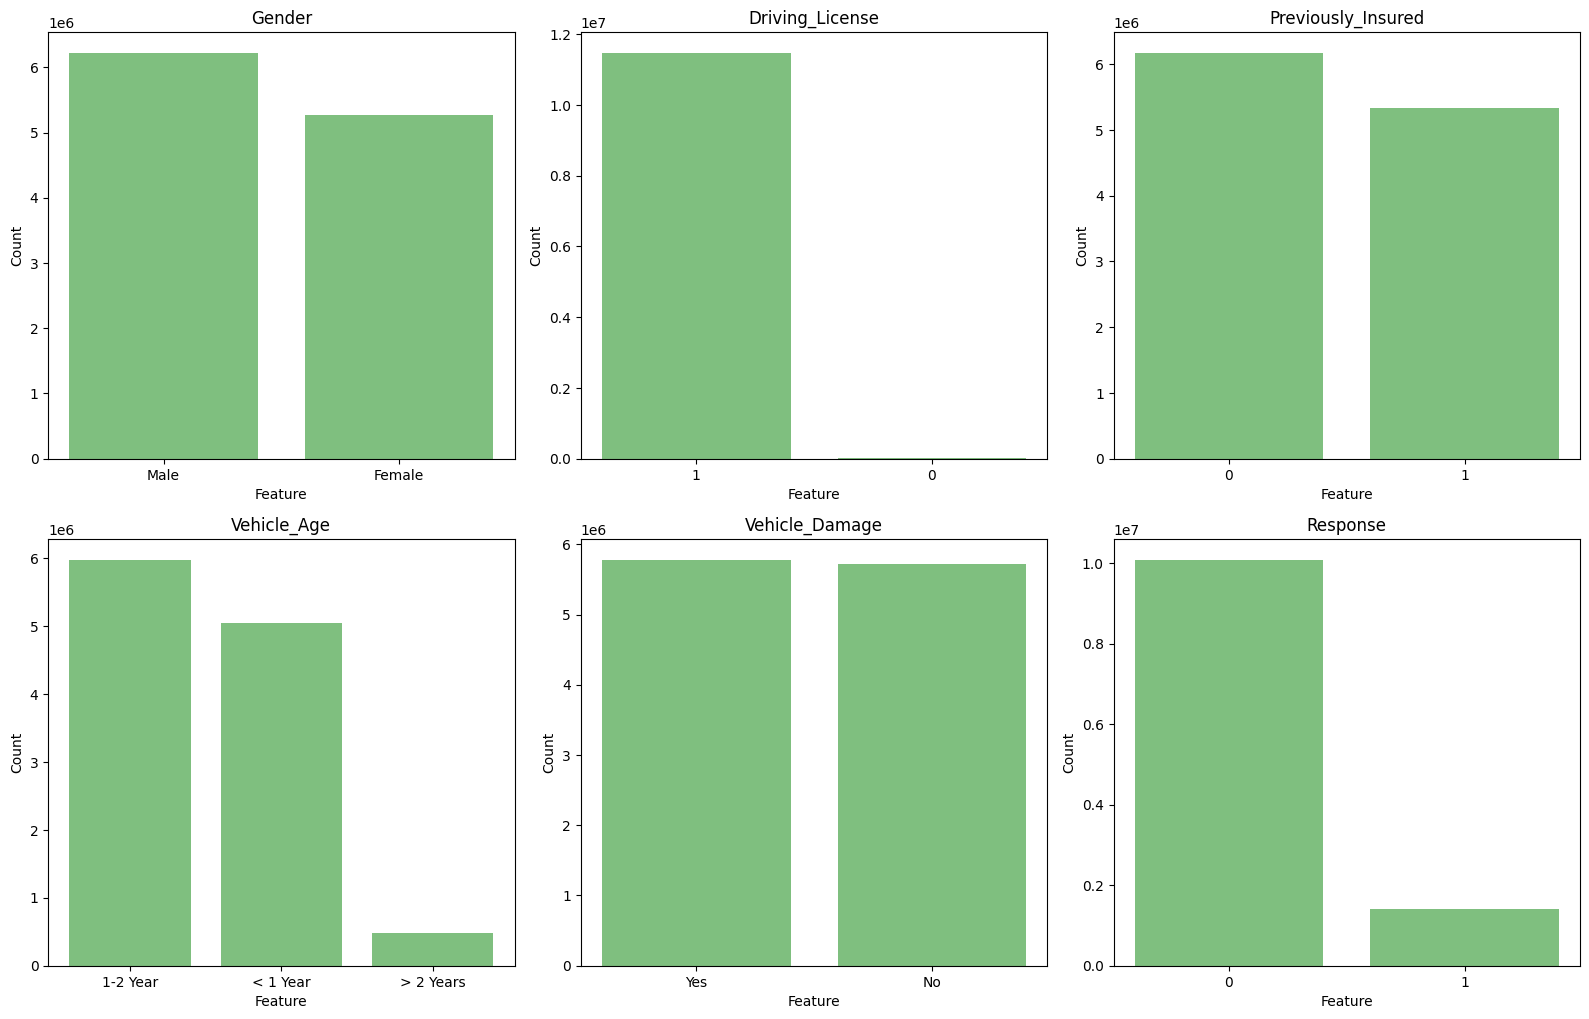

In [7]:
visu.data_overview_visualization_2(categorical_df, 'green')

# Pair Plot #

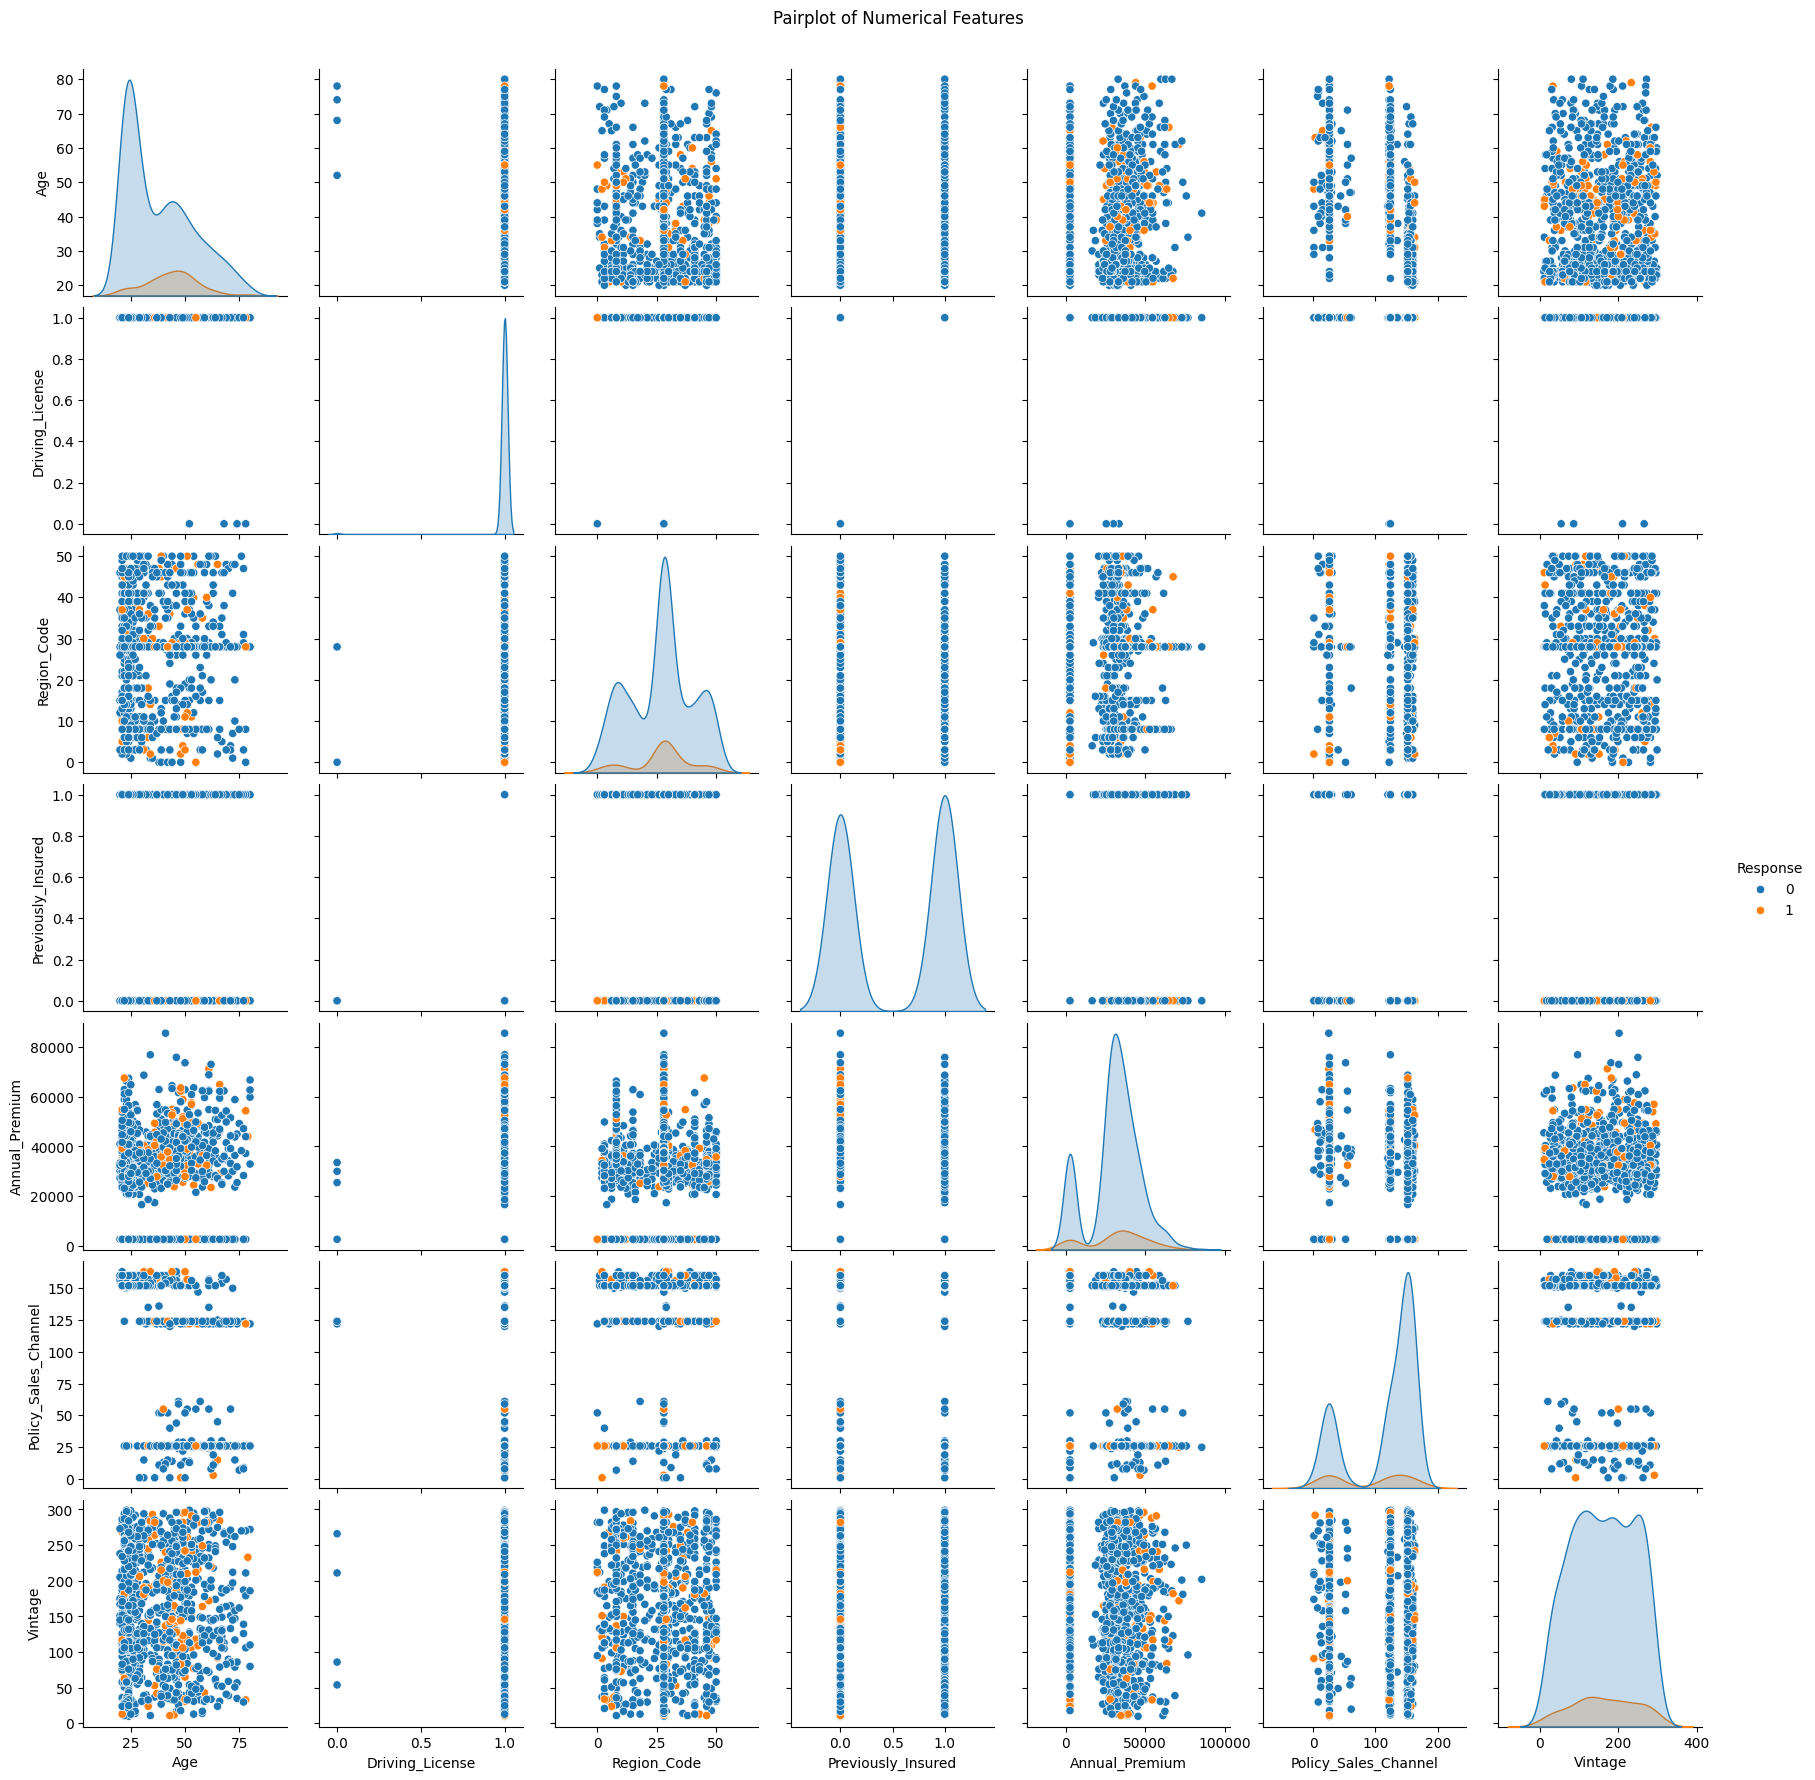

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Pairplot
sample_df = train_df.sample(1000, random_state=42)
col = sample_df.drop(columns='id')
sns.pairplot(col, hue = 'Response',corner=False)
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()

In [9]:
ft = FeatureEngineering()
# Encode Binary and Ordinal features
df_encoded = train_df.copy()
encoded_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
df_encoded[encoded_cols] = ft.ordinalEncoding(df_encoded[encoded_cols])

#Encode Categorical 
encoded_cols = ['Region_Code', 'Policy_Sales_Channel', 'Vintage']
df_encoded[encoded_cols] = ft.categoricalEncoding(df_encoded[encoded_cols])

In [10]:
df_encoded

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1,21,1,35,0,0,1,65101.0,119,177,0
1,1,1,43,1,28,0,2,1,58911.0,25,278,1
2,2,0,25,1,14,1,1,0,38043.0,142,244,0
3,3,0,35,1,1,0,0,1,2630.0,146,66,0
4,4,0,36,1,15,1,0,0,31951.0,142,284,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,1,48,1,6,0,0,1,27412.0,25,208,0
11504794,11504794,0,26,1,36,0,1,1,29509.0,142,105,1
11504795,11504795,0,29,1,32,1,1,0,2630.0,142,179,0
11504796,11504796,0,51,1,28,0,0,1,48443.0,25,264,1


# t-SNE #

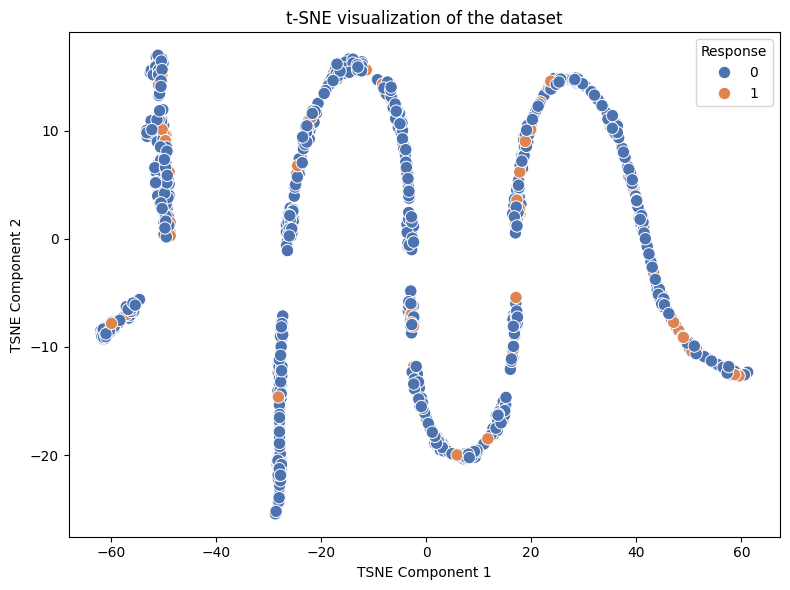

In [11]:
from sklearn.manifold import TSNE

sample_df = df_encoded.sample(1000, random_state=42)
X_data = sample_df.drop(columns=['id', 'Response'])
y_data = sample_df['Response']
# Run t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X_data)

# Create DataFrame for Seaborn
df_tsne = pd.DataFrame(X_2d, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Response'] = pd.Categorical(y_data)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x='TSNE-1', y='TSNE-2', hue='Response', palette='deep', s=80)
plt.title("t-SNE visualization of the dataset")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(title='Response')
plt.tight_layout()
plt.show()

# Features importances #

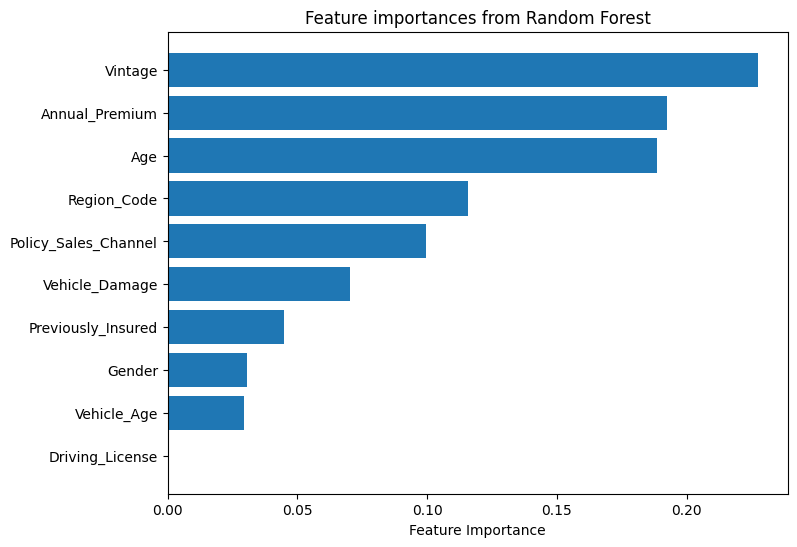

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_data, y_data)

feature_names = X_data.columns 
importances   = rf.feature_importances_
indices       = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8,6))
plt.barh(feature_names[indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("Feature importances from Random Forest")
plt.gca().invert_yaxis()  # highest at top
plt.show()